In [ ]:
#!pip install torchextractor

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic"


Mounted at /content/drive


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")


## Define the Model

In [ ]:
import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

class Args:
    def __init__(self):
        self.batch_size = 64 #16
        self.epochs = 100
        self.lr = 0.01 #0.00001
        self.momentum = 0.9
        self.seed = 1
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.parameters()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 210MB/s]


## Initialize Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class ISICDataset(Dataset):
    def __init__(self, path: str = None, is_malignant: int = None, data_files=None, labels=None, group_labels = None, transform=None):

        self.path = path
        self.data_files = os.listdir(self.path)
        self.is_malignant = is_malignant
        self.group_labels = group_labels
        self.labels = labels
        self.transform = transform

    def __getitem__(self, i):

        img = Image.open(os.path.join(self.path, self.data_files[i]))

        # Apply the provided transform
        if self.transform:
            img = self.transform(img)

        # Return the label and group label
        is_malignant = self.is_malignant
        group_label = self.group_labels[i]
        return (img, is_malignant, group_label)

    def __len__(self):
        return len(self.data_files)


## Functions for Training

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Train
train_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/malignant_no_patch'
train_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_no_patch'
train_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/train/benign_patch'

#Validate
val_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_no_patch'
val_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/malignant_patch'
val_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_no_patch'
val_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/val/benign_patch'

#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch'


# Create datasets for training and validating
dataset_train_mal_nopatch = ISICDataset(path=train_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(train_mal_nopatch_path)), transform=transform)
dataset_train_ben_nopatch = ISICDataset(path=train_ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(train_ben_nopatch_path)), transform=transform)
dataset_train_ben_patch = ISICDataset(path=train_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(train_ben_patch_path)), transform=transform)

dataset_val_mal_nopatch = ISICDataset(path=val_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(val_mal_nopatch_path)), transform=transform)
dataset_val_mal_patch = ISICDataset(path=val_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(val_mal_nopatch_path)), transform=transform)
dataset_val_ben_nopatch = ISICDataset(path=val_ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(val_ben_nopatch_path)), transform=transform)
dataset_val_ben_patch = ISICDataset(path=val_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(val_ben_patch_path)), transform=transform)



# Concatenate the training datasets
train_dataset = ConcatDataset((dataset_train_mal_nopatch, dataset_train_ben_nopatch, dataset_train_ben_patch))
val_dataset = ConcatDataset((dataset_val_mal_nopatch, dataset_val_ben_nopatch, dataset_val_ben_patch, dataset_val_mal_patch))
dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)), transform=transform)
test_dataset = dataset_test_mal_patch


batch_size = 32

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

### Val loss

In [ ]:

import os
import time
from datetime import datetime
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models


def gradient_sum(im, target, model, crit, device='cuda'):

    im.requires_grad = True
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

# Define the train_model function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, model_training_path='models', device='cuda', resume_training=False):
    since = time.time()
    best_loss = float('inf')  # Initialize best loss to a high value
    patience = 25
    cur_patience = 0

    # Create the directory if it does not exist
    if not os.path.exists(model_training_path):
        os.makedirs(model_training_path)

    if resume_training and len(os.listdir(model_training_path)) > 0:
        # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time from most to least recent
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Add 'val' phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels, group_labels in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()

                        # Apply gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

                        optimizer.step()  # Update model parameters

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_epoch = epoch
                    print(f"New best epoch: {best_epoch}, Loss: {best_loss:.4f}")
                    cur_patience = 0
                else:
                    cur_patience += 1
                    if cur_patience >= patience:
                        print("Early stopping triggered.")
                        break

        # Step the learning rate scheduler
        scheduler.step(epoch_loss)

        # Save checkpoint every 20 epochs
        if epoch % 20 == 0:
            checkpoint_path = os.path.join(model_training_path, f"epoch_{epoch}_{datetime.now().strftime('%Y%m%d%H%M%S')}.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved at epoch {epoch}!")

        if cur_patience >= patience:
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100
----------


100%|██████████| 469/469 [41:29<00:00,  5.31s/it]


train Loss: 0.4548 Acc: 0.7560


100%|██████████| 8/8 [00:50<00:00,  6.36s/it]


val Loss: 0.4007 Acc: 0.7792
New best epoch: 1, Loss: 0.4007
Epoch 2/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


train Loss: 0.3807 Acc: 0.8011


100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


val Loss: 0.3860 Acc: 0.7875
New best epoch: 2, Loss: 0.3860
Epoch 3/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.55it/s]


train Loss: 0.3629 Acc: 0.8126


100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


val Loss: 0.3908 Acc: 0.7875
Epoch 4/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


train Loss: 0.3548 Acc: 0.8208


100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


val Loss: 0.3929 Acc: 0.7875
Epoch 5/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.67it/s]


train Loss: 0.3447 Acc: 0.8228


100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


val Loss: 0.3988 Acc: 0.7958
Epoch 6/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.63it/s]


train Loss: 0.3423 Acc: 0.8283


100%|██████████| 8/8 [00:00<00:00, 11.49it/s]


val Loss: 0.3883 Acc: 0.8167
Epoch 7/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.53it/s]


train Loss: 0.3356 Acc: 0.8291


100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


val Loss: 0.4129 Acc: 0.7833
Epoch 8/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.14it/s]


train Loss: 0.3334 Acc: 0.8339


100%|██████████| 8/8 [00:00<00:00, 10.32it/s]


val Loss: 0.4345 Acc: 0.7833
Epoch 9/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.20it/s]


train Loss: 0.3306 Acc: 0.8379


100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


val Loss: 0.4136 Acc: 0.8000
Epoch 10/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.13it/s]


train Loss: 0.3232 Acc: 0.8368


100%|██████████| 8/8 [00:00<00:00, 10.34it/s]


val Loss: 0.4149 Acc: 0.8042
Epoch 11/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.03it/s]


train Loss: 0.3267 Acc: 0.8382


100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


val Loss: 0.4108 Acc: 0.8000
Epoch 12/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.07it/s]


train Loss: 0.3305 Acc: 0.8337


100%|██████████| 8/8 [00:00<00:00, 11.54it/s]


val Loss: 0.4133 Acc: 0.8083
Epoch 13/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.25it/s]


train Loss: 0.3285 Acc: 0.8340


100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


val Loss: 0.4121 Acc: 0.8083
Epoch 14/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


train Loss: 0.3232 Acc: 0.8363


100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


val Loss: 0.4143 Acc: 0.8083
Epoch 15/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


train Loss: 0.3260 Acc: 0.8352


100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


val Loss: 0.4141 Acc: 0.8083
Epoch 16/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


train Loss: 0.3201 Acc: 0.8403


100%|██████████| 8/8 [00:00<00:00, 11.50it/s]


val Loss: 0.4143 Acc: 0.8083
Epoch 17/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.07it/s]


train Loss: 0.3286 Acc: 0.8347


100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


val Loss: 0.4136 Acc: 0.8083
Epoch 18/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.27it/s]


train Loss: 0.3254 Acc: 0.8361


100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


val Loss: 0.4131 Acc: 0.8042
Epoch 19/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.21it/s]


train Loss: 0.3217 Acc: 0.8401


100%|██████████| 8/8 [00:00<00:00, 11.41it/s]


val Loss: 0.4131 Acc: 0.8042
Epoch 20/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.28it/s]


train Loss: 0.3237 Acc: 0.8398


100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


val Loss: 0.4131 Acc: 0.8083
Model checkpoint saved at epoch 20!
Epoch 21/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.20it/s]


train Loss: 0.3258 Acc: 0.8377


100%|██████████| 8/8 [00:00<00:00, 10.44it/s]


val Loss: 0.4130 Acc: 0.8083
Epoch 22/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


train Loss: 0.3277 Acc: 0.8358


100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


val Loss: 0.4129 Acc: 0.8042
Epoch 23/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


train Loss: 0.3263 Acc: 0.8339


100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


val Loss: 0.4129 Acc: 0.8042
Epoch 24/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.28it/s]


train Loss: 0.3249 Acc: 0.8371


100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


val Loss: 0.4128 Acc: 0.8042
Epoch 25/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.40it/s]


train Loss: 0.3255 Acc: 0.8395


100%|██████████| 8/8 [00:00<00:00, 10.62it/s]


val Loss: 0.4128 Acc: 0.8042
Epoch 26/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.42it/s]


train Loss: 0.3260 Acc: 0.8382


100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


val Loss: 0.4128 Acc: 0.8042
Epoch 27/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


train Loss: 0.3199 Acc: 0.8385


100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


val Loss: 0.4128 Acc: 0.8042
Early stopping triggered.
Training complete in 57m 55s
Best val loss: 0.3860


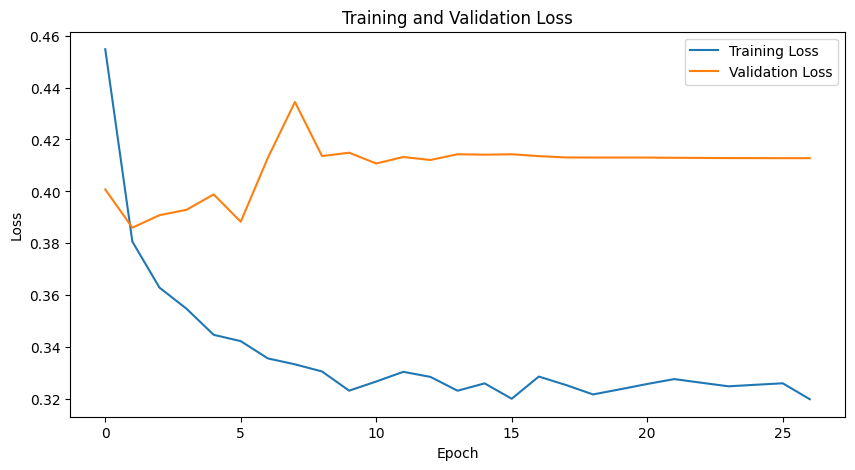

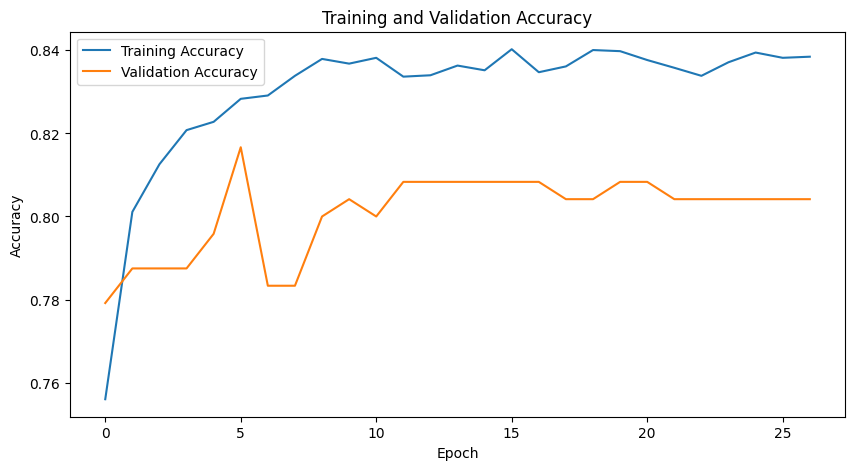

Epoch 1/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.22it/s]


train Loss: 0.4545 Acc: 0.7496


100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


val Loss: 0.3780 Acc: 0.8083
New best epoch: 1, Loss: 0.3780
Epoch 2/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


train Loss: 0.3768 Acc: 0.8068


100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


val Loss: 0.3568 Acc: 0.8125
New best epoch: 2, Loss: 0.3568
Epoch 3/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.52it/s]


train Loss: 0.3593 Acc: 0.8151


100%|██████████| 8/8 [00:00<00:00, 10.78it/s]


val Loss: 0.3783 Acc: 0.7917
Epoch 4/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.36it/s]


train Loss: 0.3540 Acc: 0.8239


100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


val Loss: 0.3619 Acc: 0.8167
Epoch 5/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.52it/s]


train Loss: 0.3441 Acc: 0.8240


100%|██████████| 8/8 [00:00<00:00, 11.48it/s]


val Loss: 0.3745 Acc: 0.8000
Epoch 6/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


train Loss: 0.3411 Acc: 0.8268


100%|██████████| 8/8 [00:00<00:00, 11.54it/s]


val Loss: 0.3725 Acc: 0.8042
Epoch 7/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.38it/s]


train Loss: 0.3366 Acc: 0.8305


100%|██████████| 8/8 [00:00<00:00, 11.46it/s]


val Loss: 0.3680 Acc: 0.8083
Epoch 8/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.42it/s]


train Loss: 0.3292 Acc: 0.8313


100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


val Loss: 0.4029 Acc: 0.8083
Epoch 9/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


train Loss: 0.3338 Acc: 0.8475


100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


val Loss: 0.3801 Acc: 0.8083
Epoch 10/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


train Loss: 0.3213 Acc: 0.8403


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


val Loss: 0.3801 Acc: 0.8083
Epoch 11/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


train Loss: 0.3226 Acc: 0.8381


100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


val Loss: 0.3779 Acc: 0.8167
Epoch 12/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


train Loss: 0.3225 Acc: 0.8403


100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


val Loss: 0.3770 Acc: 0.8125
Epoch 13/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


train Loss: 0.3197 Acc: 0.8394


100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


val Loss: 0.3810 Acc: 0.8000
Epoch 14/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.53it/s]


train Loss: 0.3227 Acc: 0.8407


100%|██████████| 8/8 [00:00<00:00, 11.37it/s]


val Loss: 0.3761 Acc: 0.8083
Epoch 15/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


train Loss: 0.3234 Acc: 0.8329


100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


val Loss: 0.3768 Acc: 0.8125
Epoch 16/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


train Loss: 0.3206 Acc: 0.8413


100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


val Loss: 0.3777 Acc: 0.8125
Epoch 17/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.12it/s]


train Loss: 0.3255 Acc: 0.8339


100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


val Loss: 0.3784 Acc: 0.8125
Epoch 18/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.42it/s]


train Loss: 0.3263 Acc: 0.8371


100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


val Loss: 0.3784 Acc: 0.8125
Epoch 19/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.41it/s]


train Loss: 0.3222 Acc: 0.8362


100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


val Loss: 0.3784 Acc: 0.8125
Epoch 20/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


train Loss: 0.3206 Acc: 0.8370


100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


val Loss: 0.3785 Acc: 0.8125
Model checkpoint saved at epoch 20!
Epoch 21/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


train Loss: 0.3181 Acc: 0.8369


100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


val Loss: 0.3786 Acc: 0.8125
Epoch 22/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.09it/s]


train Loss: 0.3201 Acc: 0.8389


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


val Loss: 0.3786 Acc: 0.8125
Epoch 23/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


train Loss: 0.3251 Acc: 0.8356


100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


val Loss: 0.3786 Acc: 0.8125
Epoch 24/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


train Loss: 0.3208 Acc: 0.8369


100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


val Loss: 0.3787 Acc: 0.8125
Epoch 25/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.17it/s]


train Loss: 0.3217 Acc: 0.8364


100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


val Loss: 0.3787 Acc: 0.8125
Epoch 26/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.36it/s]


train Loss: 0.3211 Acc: 0.8384


100%|██████████| 8/8 [00:00<00:00, 11.12it/s]


val Loss: 0.3787 Acc: 0.8125
Epoch 27/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.68it/s]


train Loss: 0.3255 Acc: 0.8335


100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


val Loss: 0.3787 Acc: 0.8125
Early stopping triggered.
Training complete in 16m 5s
Best val loss: 0.3568


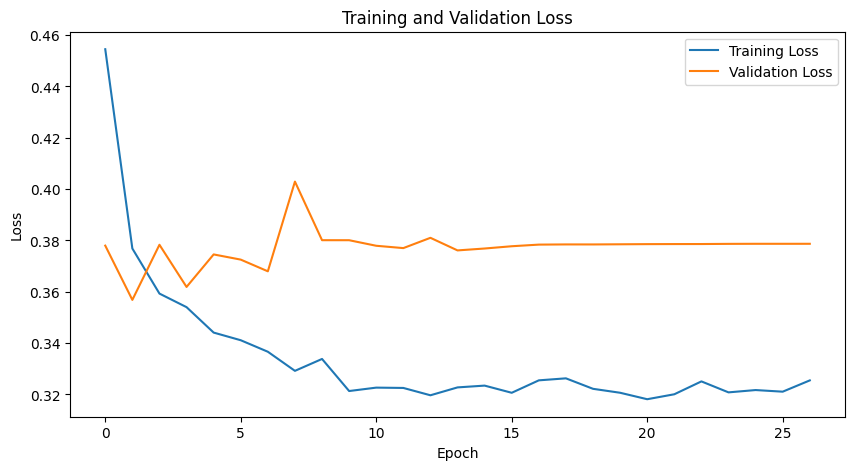

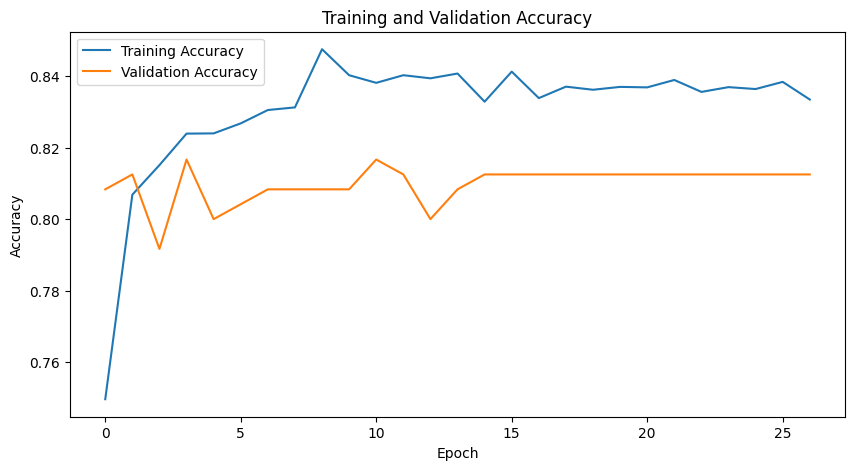

Epoch 1/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.19it/s]


train Loss: 0.4615 Acc: 0.7377


100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


val Loss: 0.3856 Acc: 0.8375
New best epoch: 1, Loss: 0.3856
Epoch 2/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.56it/s]


train Loss: 0.3847 Acc: 0.8008


100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


val Loss: 0.3892 Acc: 0.8083
Epoch 3/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.58it/s]


train Loss: 0.3679 Acc: 0.8118


100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


val Loss: 0.3593 Acc: 0.8500
New best epoch: 3, Loss: 0.3593
Epoch 4/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


train Loss: 0.3578 Acc: 0.8162


100%|██████████| 8/8 [00:00<00:00, 11.56it/s]


val Loss: 0.3804 Acc: 0.8125
Epoch 5/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.53it/s]


train Loss: 0.3480 Acc: 0.8261


100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


val Loss: 0.3771 Acc: 0.8208
Epoch 6/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.19it/s]


train Loss: 0.3411 Acc: 0.8293


100%|██████████| 8/8 [00:00<00:00, 11.61it/s]


val Loss: 0.3738 Acc: 0.8375
Epoch 7/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.07it/s]


train Loss: 0.3366 Acc: 0.8347


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


val Loss: 0.3642 Acc: 0.8542
Epoch 8/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.05it/s]


train Loss: 0.3346 Acc: 0.8301


100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


val Loss: 0.3623 Acc: 0.8458
Epoch 9/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.98it/s]


train Loss: 0.3303 Acc: 0.8322


100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


val Loss: 0.3699 Acc: 0.8208
Epoch 10/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.83it/s]


train Loss: 0.3229 Acc: 0.8375


100%|██████████| 8/8 [00:00<00:00, 11.43it/s]


val Loss: 0.3697 Acc: 0.8250
Epoch 11/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.99it/s]


train Loss: 0.3228 Acc: 0.8425


100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


val Loss: 0.3690 Acc: 0.8208
Epoch 12/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.37it/s]


train Loss: 0.3211 Acc: 0.8385


100%|██████████| 8/8 [00:00<00:00, 11.36it/s]


val Loss: 0.3687 Acc: 0.8208
Epoch 13/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.40it/s]


train Loss: 0.3240 Acc: 0.8417


100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


val Loss: 0.3659 Acc: 0.8167
Epoch 14/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


train Loss: 0.3256 Acc: 0.8394


100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


val Loss: 0.3659 Acc: 0.8167
Epoch 15/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


train Loss: 0.3228 Acc: 0.8354


100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


val Loss: 0.3694 Acc: 0.8208
Epoch 16/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.32it/s]


train Loss: 0.3197 Acc: 0.8365


100%|██████████| 8/8 [00:00<00:00, 11.14it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 17/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.09it/s]


train Loss: 0.3206 Acc: 0.8379


100%|██████████| 8/8 [00:00<00:00, 11.26it/s]


val Loss: 0.3695 Acc: 0.8208
Epoch 18/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.41it/s]


train Loss: 0.3167 Acc: 0.8413


100%|██████████| 8/8 [00:00<00:00, 11.69it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 19/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.37it/s]


train Loss: 0.3233 Acc: 0.8369


100%|██████████| 8/8 [00:00<00:00, 11.40it/s]


val Loss: 0.3698 Acc: 0.8208
Epoch 20/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


train Loss: 0.3248 Acc: 0.8362


100%|██████████| 8/8 [00:00<00:00, 11.33it/s]


val Loss: 0.3695 Acc: 0.8208
Model checkpoint saved at epoch 20!
Epoch 21/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


train Loss: 0.3255 Acc: 0.8381


100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 22/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.44it/s]


train Loss: 0.3243 Acc: 0.8354


100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 23/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


train Loss: 0.3218 Acc: 0.8377


100%|██████████| 8/8 [00:00<00:00, 11.46it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 24/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


train Loss: 0.3186 Acc: 0.8383


100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 25/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.38it/s]


train Loss: 0.3219 Acc: 0.8391


100%|██████████| 8/8 [00:00<00:00, 11.89it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 26/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.24it/s]


train Loss: 0.3215 Acc: 0.8395


100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 27/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.81it/s]


train Loss: 0.3246 Acc: 0.8376


100%|██████████| 8/8 [00:00<00:00, 10.67it/s]


val Loss: 0.3696 Acc: 0.8208
Epoch 28/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.74it/s]


train Loss: 0.3180 Acc: 0.8411


100%|██████████| 8/8 [00:00<00:00,  9.86it/s]


val Loss: 0.3696 Acc: 0.8208
Early stopping triggered.
Training complete in 16m 52s
Best val loss: 0.3593


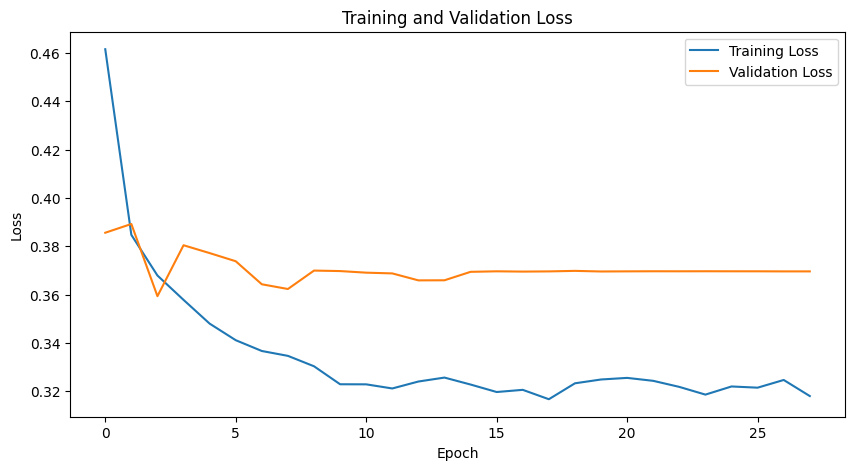

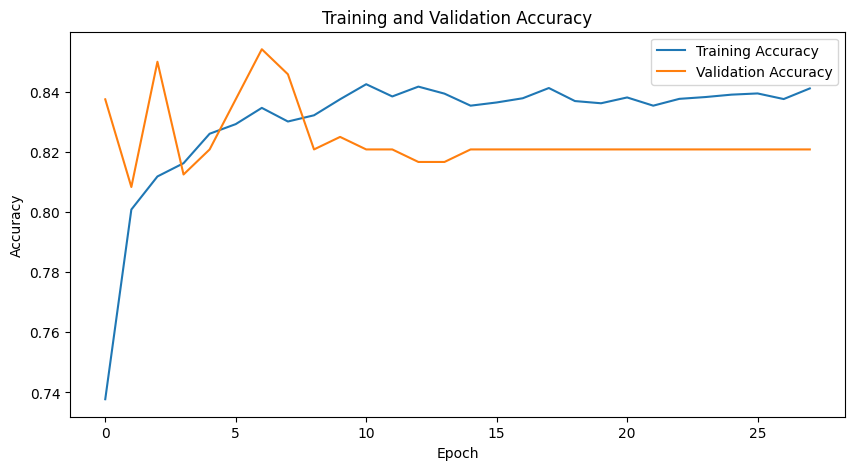

Epoch 1/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.38it/s]


train Loss: 0.4415 Acc: 0.7760


100%|██████████| 8/8 [00:00<00:00, 10.88it/s]


val Loss: 0.3680 Acc: 0.8458
New best epoch: 1, Loss: 0.3680
Epoch 2/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.66it/s]


train Loss: 0.3786 Acc: 0.8041


100%|██████████| 8/8 [00:00<00:00, 10.56it/s]


val Loss: 0.3641 Acc: 0.8167
New best epoch: 2, Loss: 0.3641
Epoch 3/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.75it/s]


train Loss: 0.3630 Acc: 0.8158


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


val Loss: 0.3672 Acc: 0.8250
Epoch 4/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.73it/s]


train Loss: 0.3528 Acc: 0.8243


100%|██████████| 8/8 [00:00<00:00, 10.85it/s]


val Loss: 0.3571 Acc: 0.8458
New best epoch: 4, Loss: 0.3571
Epoch 5/100
----------


100%|██████████| 469/469 [00:36<00:00, 13.01it/s]


train Loss: 0.3465 Acc: 0.8221


100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


val Loss: 0.3804 Acc: 0.8167
Epoch 6/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.36it/s]


train Loss: 0.3371 Acc: 0.8306


100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


val Loss: 0.3655 Acc: 0.8292
Epoch 7/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.21it/s]


train Loss: 0.3332 Acc: 0.8313


100%|██████████| 8/8 [00:00<00:00, 10.67it/s]


val Loss: 0.3933 Acc: 0.8083
Epoch 8/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.21it/s]


train Loss: 0.3267 Acc: 0.8345


100%|██████████| 8/8 [00:00<00:00, 11.20it/s]


val Loss: 0.3799 Acc: 0.8167
Epoch 9/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


train Loss: 0.3267 Acc: 0.8347


100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


val Loss: 0.3868 Acc: 0.8250
Epoch 10/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


train Loss: 0.3201 Acc: 0.8401


100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


val Loss: 0.3706 Acc: 0.8292
Epoch 11/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


train Loss: 0.3178 Acc: 0.8375


100%|██████████| 8/8 [00:00<00:00, 10.93it/s]


val Loss: 0.3770 Acc: 0.8125
Epoch 12/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.44it/s]


train Loss: 0.3174 Acc: 0.8413


100%|██████████| 8/8 [00:00<00:00, 11.81it/s]


val Loss: 0.3823 Acc: 0.8167
Epoch 13/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.54it/s]


train Loss: 0.3204 Acc: 0.8384


100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


val Loss: 0.3830 Acc: 0.8125
Epoch 14/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.44it/s]


train Loss: 0.3148 Acc: 0.8393


100%|██████████| 8/8 [00:00<00:00, 10.48it/s]


val Loss: 0.3854 Acc: 0.8167
Epoch 15/100
----------


100%|██████████| 469/469 [00:34<00:00, 13.40it/s]


train Loss: 0.3182 Acc: 0.8380


100%|██████████| 8/8 [00:00<00:00, 11.72it/s]


val Loss: 0.3870 Acc: 0.8167
Epoch 16/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


train Loss: 0.3162 Acc: 0.8446


100%|██████████| 8/8 [00:00<00:00, 11.42it/s]


val Loss: 0.3838 Acc: 0.8125
Epoch 17/100
----------


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


train Loss: 0.3177 Acc: 0.8407


100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


val Loss: 0.3840 Acc: 0.8125
Epoch 18/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.95it/s]


train Loss: 0.3181 Acc: 0.8394


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


val Loss: 0.3843 Acc: 0.8125
Epoch 19/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.43it/s]


train Loss: 0.3144 Acc: 0.8373


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


val Loss: 0.3846 Acc: 0.8125
Epoch 20/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.69it/s]


train Loss: 0.3152 Acc: 0.8433


100%|██████████| 8/8 [00:00<00:00, 10.42it/s]


val Loss: 0.3850 Acc: 0.8125
Model checkpoint saved at epoch 20!
Epoch 21/100
----------


100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


train Loss: 0.3191 Acc: 0.8407


100%|██████████| 8/8 [00:00<00:00, 10.70it/s]


val Loss: 0.3850 Acc: 0.8125
Epoch 22/100
----------


100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


train Loss: 0.3170 Acc: 0.8420


100%|██████████| 8/8 [00:00<00:00, 10.78it/s]


val Loss: 0.3851 Acc: 0.8125
Epoch 23/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.40it/s]


train Loss: 0.3201 Acc: 0.8429


100%|██████████| 8/8 [00:00<00:00, 11.36it/s]


val Loss: 0.3851 Acc: 0.8125
Epoch 24/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.44it/s]


train Loss: 0.3206 Acc: 0.8395


100%|██████████| 8/8 [00:00<00:00, 10.43it/s]


val Loss: 0.3851 Acc: 0.8125
Epoch 25/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


train Loss: 0.3125 Acc: 0.8389


100%|██████████| 8/8 [00:00<00:00, 11.26it/s]


val Loss: 0.3851 Acc: 0.8125
Epoch 26/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.41it/s]


train Loss: 0.3142 Acc: 0.8423


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


val Loss: 0.3852 Acc: 0.8125
Epoch 27/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.54it/s]


train Loss: 0.3135 Acc: 0.8421


100%|██████████| 8/8 [00:00<00:00, 10.46it/s]


val Loss: 0.3852 Acc: 0.8125
Epoch 28/100
----------


100%|██████████| 469/469 [00:36<00:00, 12.70it/s]


train Loss: 0.3161 Acc: 0.8411


100%|██████████| 8/8 [00:00<00:00, 10.27it/s]


val Loss: 0.3852 Acc: 0.8125
Epoch 29/100
----------


100%|██████████| 469/469 [00:37<00:00, 12.54it/s]


train Loss: 0.3168 Acc: 0.8392


100%|██████████| 8/8 [00:00<00:00, 10.93it/s]


val Loss: 0.3852 Acc: 0.8125
Early stopping triggered.
Training complete in 17m 58s
Best val loss: 0.3571


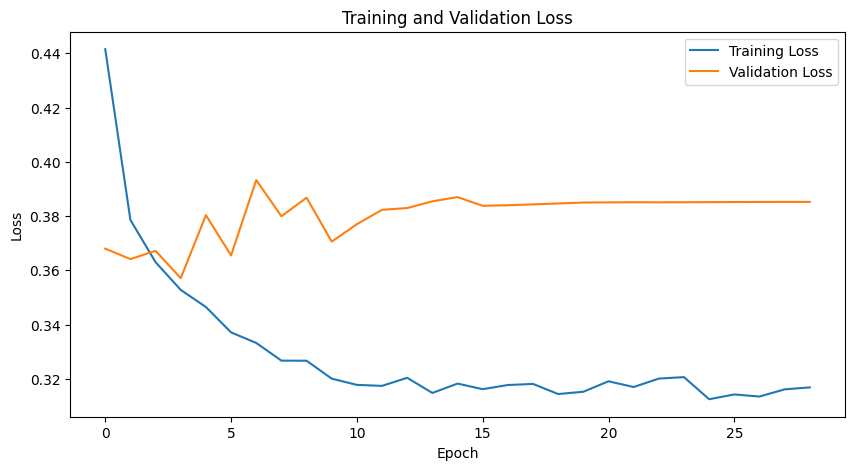

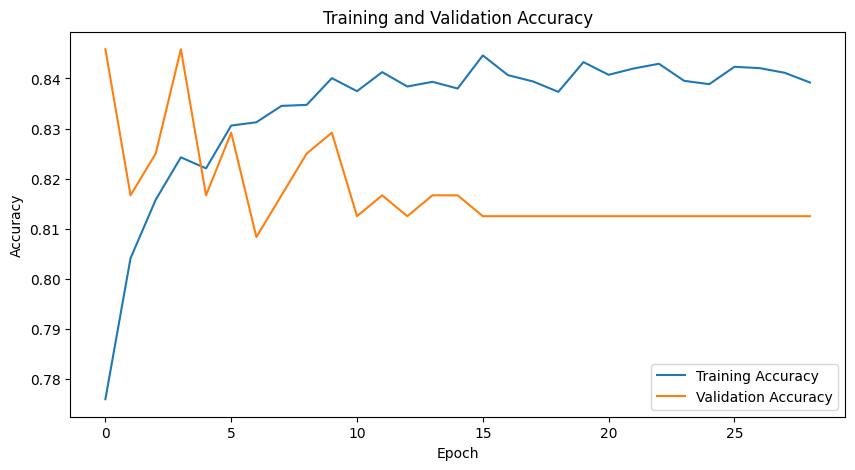

In [ ]:


#  Number of samples per class
class_counts = [13000, 1993]

# Total number of samples
total_samples = sum(class_counts)

# Calculate inverse frequency weights
weights = [total_samples / count for count in class_counts]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to tensor
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 32 #16
        self.epochs = 100
        self.lr = 0.0001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0005

seeds = [1111, 11111, 111111, 1111111]

for seed in seeds:
    args = Args(seed)
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.alexnet(pretrained=True)
    # Freeze earlier layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[-1] = nn.Linear(4096, 2)
    model.to(device)
    regularizer_rate = args.regularizer_rate
    num_epochs = args.epochs
    params_to_update = model.parameters()
    optimizer = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum, weight_decay=args.regularizer_rate)


    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, resume_training=False)
    parent_dir = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/"

    torch.save(model.state_dict(), os.path.join(parent_dir, f"alexnet_isic_{seed}" + ".pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freelze all layers
    for param in model.parameters():
        param.requires_grad = False

    print("Model loaded and layers frozen successfully")
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy




test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch'
test_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_no_patch'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_patch'
test_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_no_patch'



# Create datasets for training and validating
test_mal_patch_path = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)), transform=transform)
test_mal_nopatch_path = ISICDataset(path=test_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_nopatch_path)), transform=transform)
test_ben_nopatch_path = ISICDataset(path=test_ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(test_ben_nopatch_path)), transform=transform)
test_ben_patch_path = ISICDataset(path=test_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(test_ben_patch_path)), transform=transform)



# Create dataloaders for the test datasets
batch_size = 32
test_loader_mal_patch = DataLoader(test_mal_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_mal_nopatch = DataLoader(test_mal_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_patch = DataLoader(test_ben_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_nopatch = DataLoader(test_ben_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)


# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 1111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_mal_patch = test_model(model, test_loader_mal_patch, device)
    print(f"Accuracy on malignant with patch test dataset (class_2): {accuracy_mal_patch:.2f}%")

    # Test on original dataset
    accuracy_mal_nopatch = test_model(model, test_loader_mal_nopatch, device)
    print(f"Accuracy on malignant  without patch test dataset (class_2): {accuracy_mal_nopatch:.2f}%")

    accuracy_ben_patch = test_model(model, test_loader_ben_patch, device)
    print(f"Accuracy on benign with patch test dataset (class_2): {accuracy_ben_patch:.2f}%")

    accuracy_ben_nopatch = test_model(model, test_loader_ben_nopatch, device)
    print(f"Accuracy on benign without patch test dataset (class_2): {accuracy_ben_nopatch:.2f}%")


Loading model with seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_1.pt


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-12-40ca3378a4a7>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded successfully
Model loaded and layers frozen successfully
Accuracy on malignant with patch test dataset (class_2): 36.50%
Accuracy on malignant  without patch test dataset (class_2): 80.00%
Accuracy on benign with patch test dataset (class_2): 100.00%
Accuracy on benign without patch test dataset (class_2): 77.93%

Loading model with seed 11
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_11.pt
Model loaded successfully
Model loaded and layers frozen successfully
Accuracy on malignant with patch test dataset (class_2): 39.00%
Accuracy on malignant  without patch test dataset (class_2): 76.50%
Accuracy on benign with patch test dataset (class_2): 99.94%
Accuracy on benign without patch test dataset (class_2): 78.65%

Loading model with seed 111
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_111.pt
Model loaded successfully
Model loaded and layers frozen su

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freelze all layers
    for param in model.parameters():
        param.requires_grad = False

    print("Model loaded and layers frozen successfully")
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy




test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch'
test_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_no_patch'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_patch'
test_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_no_patch'



# Create datasets for training and validating
test_mal_patch_path = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)), transform=transform)
test_mal_nopatch_path = ISICDataset(path=test_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_nopatch_path)), transform=transform)
test_ben_nopatch_path = ISICDataset(path=test_ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(test_ben_nopatch_path)), transform=transform)
test_ben_patch_path = ISICDataset(path=test_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(test_ben_patch_path)), transform=transform)



# Create dataloaders for the test datasets
batch_size = 32
test_loader_mal_patch = DataLoader(test_mal_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_mal_nopatch = DataLoader(test_mal_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_patch = DataLoader(test_ben_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_nopatch = DataLoader(test_ben_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seeds = [21, 211, 2111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_isic_{seed}.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_mal_patch = test_model(model, test_loader_mal_patch, device)
    print(f"Accuracy on malignant with patch test dataset (class_2): {accuracy_mal_patch:.2f}%")

    # Test on original dataset
    accuracy_mal_nopatch = test_model(model, test_loader_mal_nopatch, device)
    print(f"Accuracy on malignant  without patch test dataset (class_2): {accuracy_mal_nopatch:.2f}%")

    accuracy_ben_patch = test_model(model, test_loader_ben_patch, device)
    print(f"Accuracy on benign with patch test dataset (class_2): {accuracy_ben_patch:.2f}%")

    accuracy_ben_nopatch = test_model(model, test_loader_ben_nopatch, device)
    print(f"Accuracy on benign without patch test dataset (class_2): {accuracy_ben_nopatch:.2f}%")



---





---



### Train Loss

In [ ]:
import os
import time
from datetime import datetime
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Define the gradient_sum function
def gradient_sum(im, target, model, crit, device='cuda'):
    # Assume that everything is already on cuda.
    im.requires_grad = True  # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

# Define the train_model function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, model_training_path='models', device='cuda', resume_training=False):
    since = time.time()
    best_loss = float('inf')  # Initialize best validation loss to a high value
    best_train_loss = float('inf')  # Initialize best training loss to a high value
    best_train_acc = 0.0
    best_train_acc_epoch = 0
    patience = 10
    cur_patience = 0

    # Create the directory if it does not exist
    if not os.path.exists(model_training_path):
        os.makedirs(model_training_path)

    if resume_training and len(os.listdir(model_training_path)) > 0:
        # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time from most to least recent
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels, group_labels in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()

                        # Apply gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

                        optimizer.step()  # Update model parameters

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                # Track the best training loss
                if epoch_loss < best_train_loss:
                    best_train_loss = epoch_loss
                    print(f"New best training loss at epoch {epoch}: {best_train_loss:.4f}")

                # Track the best training accuracy
                if epoch_acc > best_train_acc:
                    best_train_acc = epoch_acc
                    best_train_acc_epoch = epoch
                    print(f"New best training accuracy at epoch {best_train_acc_epoch}: {best_train_acc:.4f}")
                    cur_patience = 0  # Reset patience if training accuracy improves
                else:
                    cur_patience += 1  # Increment patience if no improvement
                    if cur_patience >= patience:
                        print("Early stopping triggered based on training accuracy.")
                        break

                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_val_epoch = epoch
                    print(f"New best validation loss at epoch {best_val_epoch}: {best_loss:.4f}")

        # Step the learning rate scheduler
        scheduler.step(epoch_loss)

        # Save checkpoint every 20 epochs
        if epoch % 20 == 0:
            checkpoint_path = os.path.join(model_training_path, f"epoch_{epoch}_{datetime.now().strftime('%Y%m%d%H%M%S')}.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved at epoch {epoch}!")

        if cur_patience >= patience:
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best training loss: {best_train_loss:.4f}')
    print(f'Best training accuracy: {best_train_acc:.4f} at epoch {best_train_acc_epoch}')
    print(f'Best validation loss: {best_loss:.4f}')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


In [ ]:


import torch

# Example: Number of samples per class
class_counts = [13000, 1993]

# Total number of samples
total_samples = sum(class_counts)

# Calculate inverse frequency weights
weights = [total_samples / count for count in class_counts]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to tensor
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)



# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 128 #16
        self.epochs = 100
        self.lr = 0.0001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0005

seeds = [38]

for seed in seeds:
    args = Args(seed)
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.alexnet(pretrained=True)

    # Freeze earlier layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[-1] = nn.Linear(4096, 2)
    model.to(device)
    regularizer_rate = args.regularizer_rate
    num_epochs = args.epochs
    params_to_update = model.parameters()
    #optimizer = optim.Adam(model.parameters(), lr=args.lr)
    #optimizer = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum, weight_decay=args.regularizer_rate)
    optimizer = optim.SGD([
    {'params': model.features.parameters(), 'lr': args.lr * 0.1},
    {'params': model.classifier.parameters(), 'lr': args.lr}
    ], momentum=0.9, weight_decay=args.regularizer_rate)

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, resume_training=False)
    parent_dir = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/"

    torch.save(model.state_dict(), os.path.join(parent_dir, f"alexnet_malwp_benp_benwp_adam_freeze{seed}_" + "train.pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freelze all layers
    for param in model.parameters():
        param.requires_grad = False

    #print("Model loaded and layers frozen successfully")
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy




test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_patch'
test_mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/malignant_no_patch'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_patch'
test_ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/full/test/benign_no_patch'



# Create datasets for training and validating
test_mal_patch_path = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)), transform=transform)
test_mal_nopatch_path = ISICDataset(path=test_mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_nopatch_path)), transform=transform)
test_ben_nopatch_path = ISICDataset(path=test_ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(test_ben_nopatch_path)), transform=transform)
test_ben_patch_path = ISICDataset(path=test_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(test_ben_patch_path)), transform=transform)



# Create dataloaders for the test datasets
batch_size = 128
test_loader_mal_patch = DataLoader(test_mal_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_mal_nopatch = DataLoader(test_mal_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_patch = DataLoader(test_ben_patch_path, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_ben_nopatch = DataLoader(test_ben_nopatch_path, batch_size=batch_size, shuffle=False, num_workers=2)


# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [34, 35, 38]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_malwp_benp_benwp_adam_freeze{seed}_train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_mal_patch = test_model(model, test_loader_mal_patch, device)
    print(f"Accuracy on malignant with patch test dataset (class_2): {accuracy_mal_patch:.2f}%")

    # Test on original dataset
    accuracy_mal_nopatch = test_model(model, test_loader_mal_nopatch, device)
    print(f"Accuracy on malignant  without patch test dataset (class_2): {accuracy_mal_nopatch:.2f}%")

    accuracy_ben_patch = test_model(model, test_loader_ben_patch, device)
    print(f"Accuracy on benign with patch test dataset (class_2): {accuracy_ben_patch:.2f}%")

    accuracy_ben_nopatch = test_model(model, test_loader_ben_nopatch, device)
    print(f"Accuracy on benign without patch test dataset (class_2): {accuracy_ben_nopatch:.2f}%")

# Archive

### Full train

In [ ]:
#Train
mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/malignant_no_patch_diff'
ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/benign_no_patch'
mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/malignant_patch'
ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/benign_patch'

#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'

# Create datasets for training and testing
dataset_mal_nopatch = ISICDataset(path=mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(mal_nopatch_path)))
dataset_ben_nopatch = ISICDataset(path=ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(ben_nopatch_path)))
dataset_mal_patch = ISICDataset(path=mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(mal_patch_path)))
dataset_ben_patch = ISICDataset(path=ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(ben_patch_path)))
dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)))



complete_dataset = ConcatDataset((dataset_mal_nopatch, dataset_ben_nopatch, dataset_ben_patch, dataset_mal_patch))
train_dataset = complete_dataset
test_dataset = dataset_test_mal_patch

batch_size = args.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])


In [ ]:
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "full_train_full_model_isic.pt"))

## Functions for Evaluation

### Evaluation Metrics

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss, log_loss, precision_score, recall_score
import matplotlib.pyplot as plt

def get_output(model, dataset, device, batch_size=64):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    model.eval()
    y_list = []
    y_hat_list = []
    group_labels_list = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for data in data_loader:
            if len(data) == 3:
                inputs, labels, group_labels = data
                group_labels_list.append(group_labels.cpu().numpy())
            else:
                inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Validate inputs
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print("NaNs or Infs detected in inputs")
                return None

            outputs = model(inputs)

            # Check for NaNs in raw outputs
            if torch.isnan(outputs).any():
                print("Error: NaNs detected in model outputs before softmax.")
                print("Output stats: min=", torch.min(outputs), "max=", torch.max(outputs), "mean=", torch.mean(outputs))
                return None

            y_list.append(labels.cpu().numpy())
            y_hat_list.append(softmax(outputs).cpu().numpy()[:, 1])  # Extract probabilities for the positive class

    y = np.concatenate(y_list)
    y_hat = np.concatenate(y_hat_list)
    group_labels = np.concatenate(group_labels_list) if group_labels_list else None

    # Convert probabilities to binary predictions
    preds = (y_hat >= 0.5).astype(int)

    # Calculate TP, TN, FP, FN
    tp = ((preds == 1) & (y == 1)).sum()
    tn = ((preds == 0) & (y == 0)).sum()
    fp = ((preds == 1) & (y == 0)).sum()
    fn = ((preds == 0) & (y == 1)).sum()

    # Print intermediate results for debugging
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'y: {np.bincount(y)}, preds: {np.bincount(preds)}')  # Check distribution of labels and predictions

    return y, y_hat, group_labels, tp, tn, fp, fn


## Experiment 1:



   

### Baseline
Full training dataset

Test 1: malignant with patch

Test 2: Malignant without patch

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(pretrained=False)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240713135814full_train_full_model_isic.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'

dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[2] * len(os.listdir(test_mal_patch_path)))
dataset_test_mal_no_patch = ISICDataset(path=test_mal_no_patch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_no_patch_path)))

test_dataset_patch = dataset_test_mal_patch
test_dataset_no_patch = dataset_test_mal_no_patch

Test 1: malignant with patch

In [ ]:
results = get_output(model, test_dataset_patch, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


Test 2: Malignant without patch

In [ ]:
results = get_output(model, test_dataset_no_patch, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


### Main Experiment



*   Training set: on wb_no patch, lb_patch and lb_no patch.
*   Testing sets:
1. *mal_no_patch*
2. *mal_patch*



In [ ]:
#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'

dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)))
dataset_test_mal_no_patch = ISICDataset(path=test_mal_no_patch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_no_patch_path)))

test_dataset_patch = dataset_test_mal_patch
test_dataset_no_patch = dataset_test_mal_no_patch



In [ ]:
# Initialize AlexNet with modified classifier
model = models.alexnet(pretrained=False)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240713133629selective_train_full_model_isic.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Test 1: Malignant no patch

In [ ]:
results = get_output(model, test_dataset_no_patch, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


Test 2: Malignant with patch

In [ ]:
results = get_output(model, test_dataset_patch, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


## Experiment 2

###  Baseline Performance Test:

Full training dataset: mal patch, mal no patch, ben patch and ben no patch

Test 1: mal no patch, ben patch and ben no patch

Test 2: mal patch, mal no patch, ben patch and ben no patch


In [ ]:
model = models.alexnet(pretrained=False)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240713135814full_train_full_model_isic.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/benign_patch'
test_ben_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/benign_no_patch'


# Create datasets for testing
dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)))
dataset_test_mal_no_patch = ISICDataset(path=test_mal_no_patch_path, is_malignant=1,group_labels=[0] * len(os.listdir(test_mal_no_patch_path)))
dataset_test_ben_patch = ISICDataset(path=test_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(test_ben_patch_path)))
dataset_test_ben_no_patch = ISICDataset(path=test_ben_no_patch_path, is_malignant=0, group_labels=[2] * len(os.listdir(test_ben_no_patch_path)))

test_dataset_selective = ConcatDataset((dataset_test_mal_no_patch, dataset_test_ben_patch, dataset_test_ben_no_patch))
test_dataset_full = ConcatDataset((dataset_test_mal_no_patch, dataset_test_ben_patch, dataset_test_ben_no_patch, dataset_test_mal_patch))



Test 1: mal no patch, ben patch and ben no patch

In [ ]:
results = get_output(model, test_dataset_selective, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


Test 2: mal patch, mal no patch, ben patch and ben no patch

In [ ]:
results = get_output(model, test_dataset_full, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


### Main Experiment:

Selective training dataset:  mal no patch, ben patch and ben no patch

Test 1: mal no patch, ben patch and ben no patch

Test 2: mal patch, mal no patch, ben patch and ben no patch


In [ ]:
model = models.alexnet(pretrained=False)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240713133629selective_train_full_model_isic.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
#Test
test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'
test_ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/benign_patch'
test_ben_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/benign_no_patch'


# Create datasets for testing
dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(test_mal_patch_path)))
dataset_test_mal_no_patch = ISICDataset(path=test_mal_no_patch_path, is_malignant=1,group_labels=[0] * len(os.listdir(test_mal_no_patch_path)))
dataset_test_ben_patch = ISICDataset(path=test_ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(test_ben_patch_path)))
dataset_test_ben_no_patch = ISICDataset(path=test_ben_no_patch_path, is_malignant=0, group_labels=[2] * len(os.listdir(test_ben_no_patch_path)))

test_dataset_selective = ConcatDataset((dataset_test_mal_no_patch, dataset_test_ben_patch, dataset_test_ben_no_patch))
test_dataset_full = ConcatDataset((dataset_test_mal_no_patch, dataset_test_ben_patch, dataset_test_ben_no_patch, dataset_test_mal_patch))



Test 1: mal no patch, ben patch and ben no patch

In [ ]:
results = get_output(model, test_dataset_selective, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


Test 2: mal patch, mal no patch, ben patch and ben no patch


In [ ]:
results = get_output(model, test_dataset_full, device)

if results is None:
    print("Error detected in model output or data preprocessing.")
else:
    y, y_hat, group_labels, tp, tn, fp, fn = results
    preds = (y_hat >= 0.5).astype(int)  # Add definition for preds here
    print(f"y_hat: {y_hat}")
    print(f"Predictions: {preds}")

    # Calculate additional metrics if necessary
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

    auc_score = roc_auc_score(y, y_hat) if len(np.unique(y)) > 1 else None
    f1 = f1_score(y, preds) if len(np.unique(y)) > 1 else None
    acc = accuracy_score(y, preds)
    brier = brier_score_loss(y, y_hat)

    print(f"AUC Score: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Brier Score: {brier}")


## Extracting activations: Correlations

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_isic_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
no_patch_isic_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_malwo_benwp_benwo_1_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_malwo_benwp_benwo_2_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/alexnet_malwo_benwp_benwo_3_train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_isic_folder_path, no_patch_isic_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


Layer-wise activations

In [ ]:

from torchvision import models, transforms
from PIL import Image
import gc

# Load pre-trained alexnet model
model = models.alexnet(pretrained=False)

model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240726220923alexnet_malwo_benwp_benwo_selective_train.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_paths, layer):
    activations = []
    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)
            image_tensor = preprocess(image).unsqueeze(0).to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.squeeze().cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(folder_path, layers, batch_size=10):
    all_layer_activations = {layer: [] for layer in layers}

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    for layer in layers:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            print(f"Processing batch {i // batch_size + 1}/{(len(image_paths) - 1) // batch_size + 1} for layer {layer}")

            activations = preprocess_and_extract_activations(batch_paths, layer)
            if activations is not None:
                all_layer_activations[layer].extend(activations)
            else:
                print(f"Failed to process batch {i // batch_size + 1}")

            torch.cuda.empty_cache()
            gc.collect()

    return all_layer_activations

# Define layers of interest
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]  # Indices of layers in model.features and model.classifier

# Folder paths for images
patch_mal_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
no_patch_mal_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'

#test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
#test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim_subset'

# Process images in folders for each layer
wp_mal_all_activations = process_images_in_folder(patch_mal_folder_path, layers_of_interest)
wo_mal_all_activations = process_images_in_folder(no_patch_mal_folder_path, layers_of_interest)

# Layer names corresponding to the indices in layers_of_interest
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}

# Generate histograms for each layer
for layer_idx in layers_of_interest:
    wp_activations = wp_mal_all_activations[layer_idx]
    wo_activations = wo_mal_all_activations[layer_idx]

    if wp_activations:
        print(f"Layer {layer_idx} wp_mal_all_activations shape:", np.vstack(wp_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wp_mal_all_activations")

    if wo_activations:
        print(f"Layer {layer_idx} wo_mal_all_activations shape:", np.vstack(wo_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wo_mal_all_activations")

    if wp_activations and wo_activations:
        wp_activations_array = np.vstack(wp_activations).reshape(len(wp_activations), -1)
        wo_activations_array = np.vstack(wo_activations).reshape(len(wo_activations), -1)

        # Combine activations with patch/no-patch labels
        patch_no_patch = np.hstack([np.zeros(len(wo_activations_array)), np.ones(len(wp_activations_array))])
        combined_activations = np.concatenate((patch_no_patch[:, np.newaxis], np.vstack((wo_activations_array, wp_activations_array))), axis=1)

        # Calculate correlation matrix in chunks to save memory
        chunk_size = 1000
        activations_corr = []
        for start in range(0, combined_activations.shape[1], chunk_size):
            end = min(start + chunk_size, combined_activations.shape[1])
            corr_chunk = np.corrcoef(combined_activations[:, start:end], rowvar=False)
            activations_corr.append(np.abs(corr_chunk[0, 1:]))

        activations_corr = np.concatenate(activations_corr)

        # Plot histogram
        hist, bins = np.histogram(activations_corr, bins='auto')
        plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
        plt.title(f'{layer_names[layer_idx]} Histogram of Activations Correlation')
        plt.xlabel('Correlation')
        plt.ylabel('Number of Neurons')
        plt.show()

        # Clear activations after use
        del wp_activations
        del wo_activations
        del wp_activations_array
        del wo_activations_array
        gc.collect()

## Extracting activations: T-tests

Single sample t test. Activations not normalized

In [ ]:
from scipy.stats import ttest_1samp

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Load the activations
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])  # Combine all activations for wp across models
        wo_activations = np.vstack(data['wo'])  # Combine all activations for wo across models

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)  # t-test for wp activations
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)  # t-test for wo activations

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

t_test_results = perform_t_tests(all_layer_activations)

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means}")
        print(f"    T-statistic: {wp_ttest.statistic}")
        print(f"    P-value: {wp_ttest.pvalue}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means}")
        print(f"    T-statistic: {wo_ttest.statistic}")
        print(f"    P-value: {wo_ttest.pvalue}")

print_t_test_results(t_test_results)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols  # Calculate rows needed for the number of columns

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_p_values(t_test_results)


Single sample t test. Activations normalized

In [ ]:


# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print(f"    T-statistic: {wp_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wp_ttest.pvalue.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print(f"    T-statistic: {wo_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wo_ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)


Two sample t test. Activations normalized

In [ ]:
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_two_sample_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

Two sample t test without normalizing activations

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/isic/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

## Archived: Extracting activations from Last FC Layer



---



In [ ]:
# Load pre-trained alexnet model
model = models.alexnet(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240712204007selective_train_full_model_isic.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    for layer_idx, layer in enumerate(model.classifier[:4], start=1):
        image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    activations = model.classifier[4](image_tensor)
    activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing images
#patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#no_patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained alexnet model
model = models.alexnet(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/isic/models/initial_classifier/20240712204007selective_train_full_model_isic.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        print(f"Image loaded: {image_path}")  # Debug: Check if image is loaded
        # unsqueeze(0) adds an extra dimension to simulate a batch of size 1
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        print(f"Image preprocessed: {image_tensor.shape}")  # Debug: Check the tensor shape

        # Flatten the tensor before passing it to the linear layers
        image_tensor = model.features(image_tensor)
        print(f"Features extracted: {image_tensor.shape}")  # Debug: Check the tensor shape after features
        image_tensor = model.avgpool(image_tensor)
        image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor
        print(f"Tensor flattened: {image_tensor.shape}")  # Debug: Check the flattened tensor shape

        # Sequentially pass the tensor through the first five layers of the classifier
        # Pass through the classifier layers up to fc2 (model.classifier[4])
        for layer_idx, layer in enumerate(model.classifier[:5], start=1):
            if layer_idx == 5:
                break
            image_tensor = layer(image_tensor)
            print(f"Layer {layer_idx} output shape: {image_tensor.shape}")  # Debug: Check the output shape of each layer

        # Extract activations from the sixth linear layer of the classifier
        activations = model.classifier[4](image_tensor)
        activations = activations.squeeze().cpu().detach().numpy()
        print(f"Activations extracted: {activations.shape}")  # Debug: Check the activations shape
        return activations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                print(f"Processing image: {image_path}")  # Debug: print the image path being processed
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
                else:
                    print(f"Failed to process image: {image_path}")  # Debug: print if image processing failed
    return all_activations

# Folder path containing images
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")


In [ ]:
# each row corresponds to the activations of one image.
#np.vstack(wp_waterbird_all_activations).shape

In [ ]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy',np.vstack(wp_waterbird_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy',np.vstack(wo_waterbird_all_activations))

In [ ]:
#folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_patch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_nopatch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
folder_path_waterbird_patch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
folder_path_waterbird_nopatch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

files_patch= os.listdir(folder_path_waterbird_patch)
files_nopatch= os.listdir(folder_path_waterbird_nopatch)


num_waterbird_patch_test = len(files_patch)
num_waterbird_nopatch_test = len(files_nopatch)


patch_no_patch = np.hstack([np.zeros((1,num_waterbird_nopatch_test)),np.ones((1,num_waterbird_patch_test))])

wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [ ]:
wop_activations.shape

In [ ]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

In [ ]:
patch_no_patch.shape

In [ ]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [ ]:
activations_corr.shape

In [ ]:
print(activations_corr)

In [ ]:
'''
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset
from PIL import Image
from torchvision import transforms

class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, path: str, is_malignant: int, group_labels: list):
        self.path = path
        self.data_files = os.listdir(self.path)
        self.is_malignant = is_malignant
        self.group_labels = group_labels

    def __getitem__(self, i):
        img = Image.open(os.path.join(self.path, self.data_files[i]))
        img_array = np.asarray(img) / 255.0  # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :]  # Subtract the mean for normalization
        img_array /= std[None, None, :]  # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0, 2).swapaxes(1, 2)).float()  # Convert the numpy array to a PyTorch tensor and rearrange the axes
        is_malignant = self.is_malignant
        group_label = self.group_labels[i]
        return (torch_img, is_malignant, group_label)

    def __len__(self):
        return len(self.data_files)

def validate_inputs(data_loader):
    for data in data_loader:
        inputs, labels = data[:2]
        if torch.isnan(inputs).any():
            print("NaNs detected in input data")
            return False
        if torch.isinf(inputs).any():
            print("Infinite values detected in input data")
            return False
        print("Input stats: min=", torch.min(inputs), "max=", torch.max(inputs), "mean=", torch.mean(inputs))
    return True

# Paths
mal_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/malignant_no_patch_diff'
ben_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/benign_no_patch'
mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/malignant_patch'
ben_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/train/benign_patch'

test_mal_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_patch'
test_mal_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/isic/data/test/malignant_no_patch_sim'

# Create datasets
dataset_mal_nopatch = ISICDataset(path=mal_nopatch_path, is_malignant=1, group_labels=[0] * len(os.listdir(mal_nopatch_path)))
dataset_ben_nopatch = ISICDataset(path=ben_nopatch_path, is_malignant=0, group_labels=[2] * len(os.listdir(ben_nopatch_path)))
dataset_mal_patch = ISICDataset(path=mal_patch_path, is_malignant=1, group_labels=[1] * len(os.listdir(mal_patch_path)))
dataset_ben_patch = ISICDataset(path=ben_patch_path, is_malignant=0, group_labels=[3] * len(os.listdir(ben_patch_path)))

dataset_test_mal_patch = ISICDataset(path=test_mal_patch_path, is_malignant=1, group_labels=[2] * len(os.listdir(test_mal_patch_path)))
dataset_test_mal_no_patch = ISICDataset(path=test_mal_no_patch_path, is_malignant=1, group_labels=[0] * len(os.listdir(test_mal_no_patch_path)))

complete_dataset = ConcatDataset((dataset_mal_nopatch, dataset_ben_nopatch, dataset_mal_patch, dataset_ben_patch))
train_dataset = complete_dataset
test_dataset_patch = dataset_test_mal_patch
test_dataset_no_patch = dataset_test_mal_no_patch

# Dataloaders
batch_size = 32  # Assuming a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset_patch, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
if not validate_inputs(train_loader):
    print("Input data contains invalid values.")

# Model and Training Steps

import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Example: Initialize model with proper weights
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Adjust the final layer for binary classification

# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)

# Optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Training with gradient clipping
num_epochs = 10  # Assuming 10 epochs for demonstration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Validate model outputs
def get_output(model, dataset, device, batch_size=64):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    model.eval()
    y_list = []
    y_hat_list = []
    group_labels_list = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for data in data_loader:
            if len(data) == 3:
                inputs, labels, group_labels = data
                group_labels_list.append(group_labels.cpu().numpy())
            else:
                inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Validate inputs
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print("NaNs or Infs detected in inputs")
                return None

            outputs = model(inputs)

            # Check for NaNs in raw outputs
            if torch.isnan(outputs).any():
                print("Error: NaNs detected in model outputs before softmax.")
                print("Output stats: min=", torch.min(outputs), "max=", torch.max(outputs), "mean=", torch.mean(outputs))
                return None

            y_list.append(labels.cpu().numpy())
            y_hat_list.append(softmax(outputs).cpu().numpy()[:, 1])  # Extract probabilities for the positive class

    y = np.concatenate(y_list)
    y_hat = np.concatenate(y_hat_list)
    group_labels = np.concatenate(group_labels_list) if group_labels_list else None

    # Convert probabilities to binary predictions
    preds = (y_hat >= 0.5).astype(int)

    # Calculate TP, TN, FP, FN
    tp = ((preds == 1) & (y == 1)).sum()
    tn = ((preds == 0) & (y == 0)).sum()
    fp = ((preds == 1) & (y == 0)).sum()
    fn = ((preds == 0) & (y == 1)).sum()

    # Print intermediate results for debugging
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'y: {np.bincount(y)}, preds: {np.bincount(preds)}')  # Check distribution of labels and predictions

    return y, y_hat, group_labels, tp, tn, fp, fn
'''
